# Analyse du dataset ECONOMY — modèle Random Forest

On reprend les étapes d'analyse communes, mais uniquement sur les vols Economy, pour vérifier si le modèle apprend mieux les détails fins des prix (durée, escales, jours restants) une fois la classe retirée.

In [1]:
import numpy as np
import pandas as pd
import sklearn
 
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

# Prétraitement
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
 
# Prétraitement
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
 
# Modèles de Machine Learning
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import joblib
from sklearn.tree import export_text
 
# Évaluation des modèles
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    mean_squared_error,
    r2_score
)

In [2]:
data = pd.read_csv("./Clean_Dataset.csv")

data = data[data['class'] != 'Business']
data.drop(columns=['class'], inplace=True)

print(data.head(10))

column_nan_count = data.isnull().sum()
print("NaN count per column:")
print(column_nan_count)

   Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   
5           5   Vistara   UK-945       Delhi        Morning  zero   
6           6   Vistara   UK-927       Delhi        Morning  zero   
7           7   Vistara   UK-951       Delhi      Afternoon  zero   
8           8  GO_FIRST   G8-334       Delhi  Early_Morning  zero   
9           9  GO_FIRST   G8-336       Delhi      Afternoon  zero   

    arrival_time destination_city  duration  days_left  price  
0          Night           Mumbai      2.17          1   5953  
1        Morning           Mumbai      2.33          1   5953  
2  Early_Morning           Mumbai      2.17     

In [3]:
print(data.describe())

          Unnamed: 0       duration      days_left          price
count  206666.000000  206666.000000  206666.000000  206666.000000
mean   103332.500000      11.550060      26.123673    6572.342383
std     59659.479704       7.241284      13.529610    3743.519517
min         0.000000       0.830000       1.000000    1105.000000
25%     51666.250000       6.250000      15.000000    4173.000000
50%    103332.500000      10.170000      26.000000    5772.000000
75%    154998.750000      15.250000      38.000000    7746.000000
max    206665.000000      49.830000      49.000000   42349.000000


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 206666 entries, 0 to 206665
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        206666 non-null  int64  
 1   airline           206666 non-null  object 
 2   flight            206666 non-null  object 
 3   source_city       206666 non-null  object 
 4   departure_time    206666 non-null  object 
 5   stops             206666 non-null  object 
 6   arrival_time      206666 non-null  object 
 7   destination_city  206666 non-null  object 
 8   duration          206666 non-null  float64
 9   days_left         206666 non-null  int64  
 10  price             206666 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 18.9+ MB
None


# Colonnes :
- `Unnamed: 0` : index technique, à supprimer
- `airline` : nom de la compagnie aérienne (catégorielle)
- `flight` : code de vol, à supprimer (trop spécifique, inutile pour la prédiction)
- `source_city` : ville de départ (catégorielle)
- `departure_time` : créneau de départ ("Early_Morning", "Morning", "Afternoon", "Evening", "Night")
- `stop` : nombre d'escales
- `arrival_time` : créneau d'arrivée ("Early_Morning", "Morning", "Afternoon", "Evening", "Night")
- `destination_city` : ville d'arrivée (catégorielle)
- `duration` : durée du vol en heures (numérique)
- `days_left` : nombre de jours avant le départ (numérique)
- `price` : prix du billet en roupies indiennes — **variable cible**

In [5]:
df = data.drop(columns=['Unnamed: 0'], inplace=False)
df = df.drop(columns=['flight'], inplace=False)
# df = df.drop(columns=['airline'], inplace=False)

## Duplicates et valeurs manquantes

In [6]:
duplicate_count = df.duplicated().sum()
missing_values = df.isnull().sum()

df.drop_duplicates(inplace=True)
print(f"Nombre de doublons supprimés : {duplicate_count}")
print("Valeurs manquantes par colonne :")
print(missing_values)

Nombre de doublons supprimés : 1899
Valeurs manquantes par colonne :
airline             0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
duration            0
days_left           0
price               0
dtype: int64


### Graphes pour visualiser les valeurs aberrantes et la distribution des données

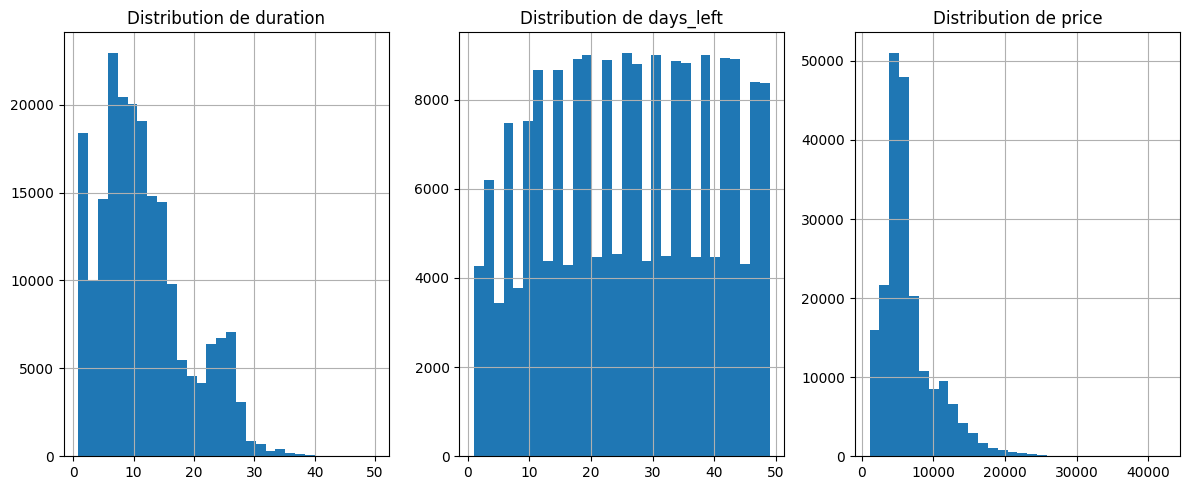

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
df.hist(column='duration', bins=30, ax=axes[0])
df.hist(column='days_left', bins=30, ax=axes[1])
df.hist(column='price', bins=30, ax=axes[2])
axes[0].set_title('Distribution de duration')
axes[1].set_title('Distribution de days_left')
axes[2].set_title('Distribution de price')
plt.tight_layout()
plt.show()

La distribution de `price` présente une asymétrie à droite (skewness positive). On garde ce point en tête, car cela peut influencer la performance du modèle.

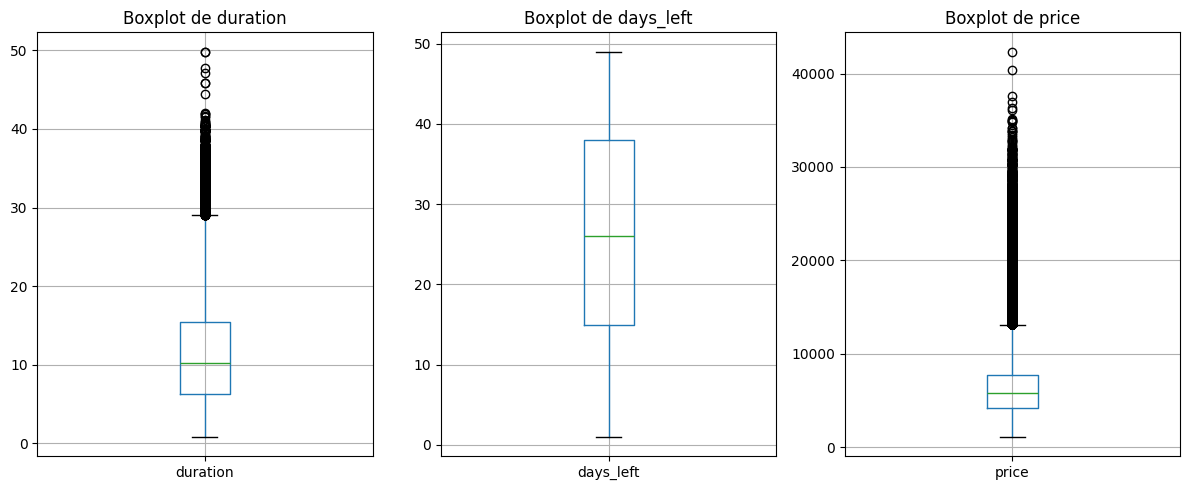

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
df.boxplot(column='duration', ax=axes[0])
df.boxplot(column='days_left', ax=axes[1])
df.boxplot(column='price', ax=axes[2])
axes[0].set_title('Boxplot de duration')
axes[1].set_title('Boxplot de days_left') 
axes[2].set_title('Boxplot de price') 
plt.tight_layout()
plt.show()

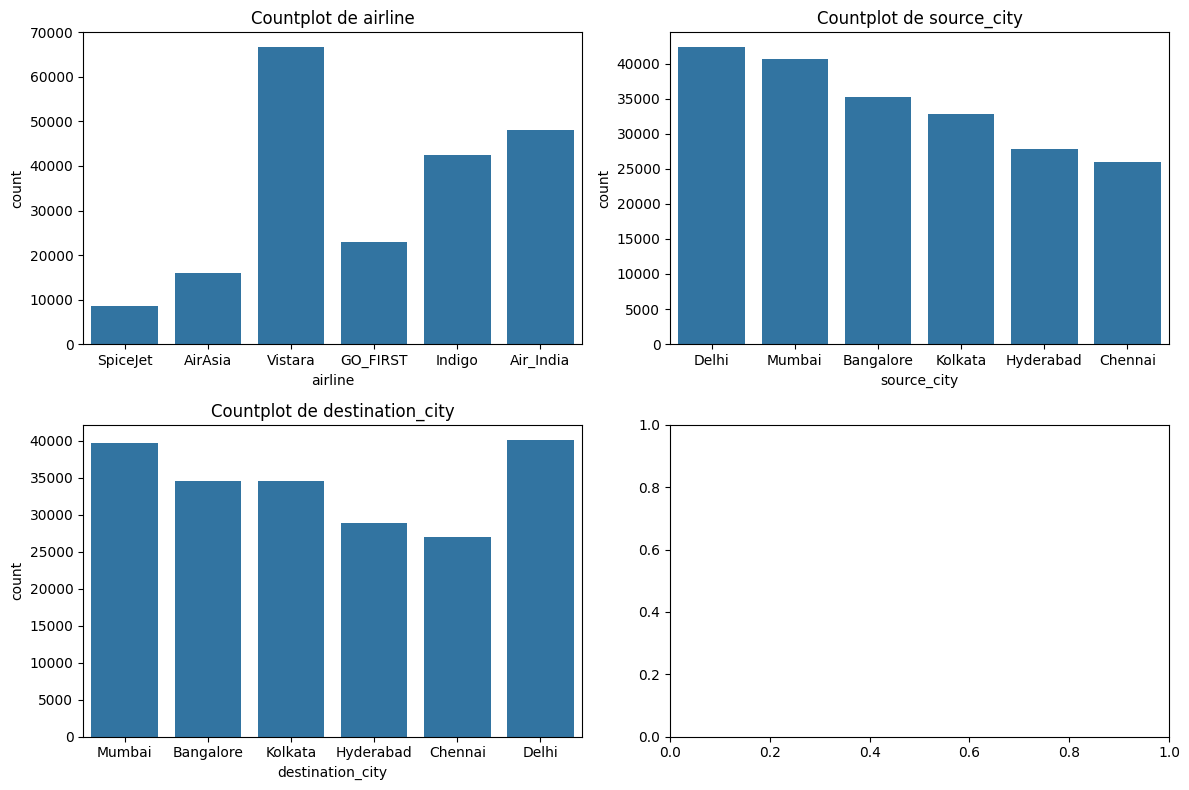

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.countplot(x=df['source_city'], ax=axes[0, 1])
axes[0, 1].set_title('Countplot de source_city')
sns.countplot(x=df['destination_city'], ax=axes[1, 0])
axes[1, 0].set_title('Countplot de destination_city')
sns.countplot(x=df['airline'], ax=axes[0, 0])
axes[0, 0].set_title('Countplot de airline')
plt.tight_layout()
plt.show()

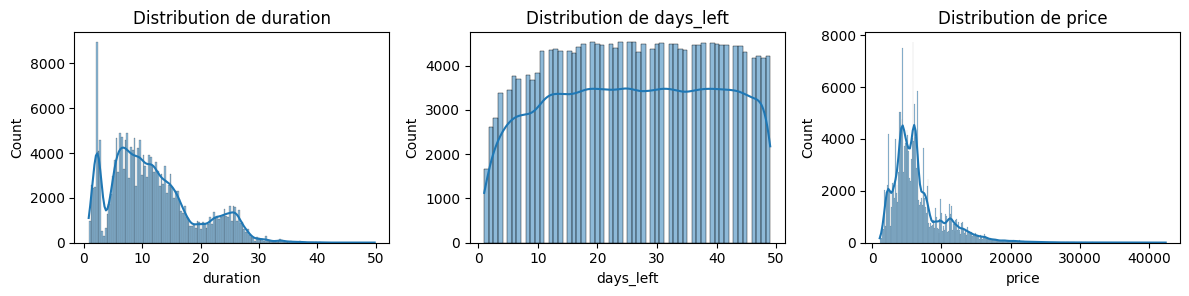

In [10]:
df_num = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
for i, column in enumerate(df_num.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_num[column], kde=True)
    plt.title(f'Distribution de {column}')
plt.tight_layout()
plt.show()

## Correlation entre les variables

Corrélation avec encodage OrdinalEncoder et OneHotEncoder pour inclure les variables catégorielles dans la matrice de corrélation.

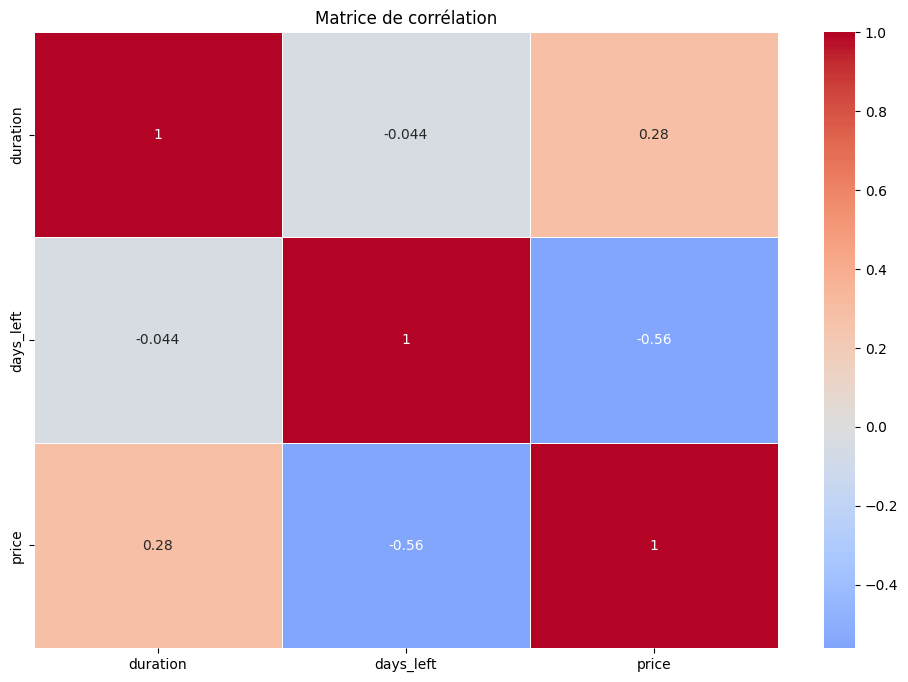

In [11]:
df_num = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

Par rapport au modèle de base, la corrélation entre `duration` et `price` devient visible (~0.28), ce qui n'apparaissait pas clairement avant.

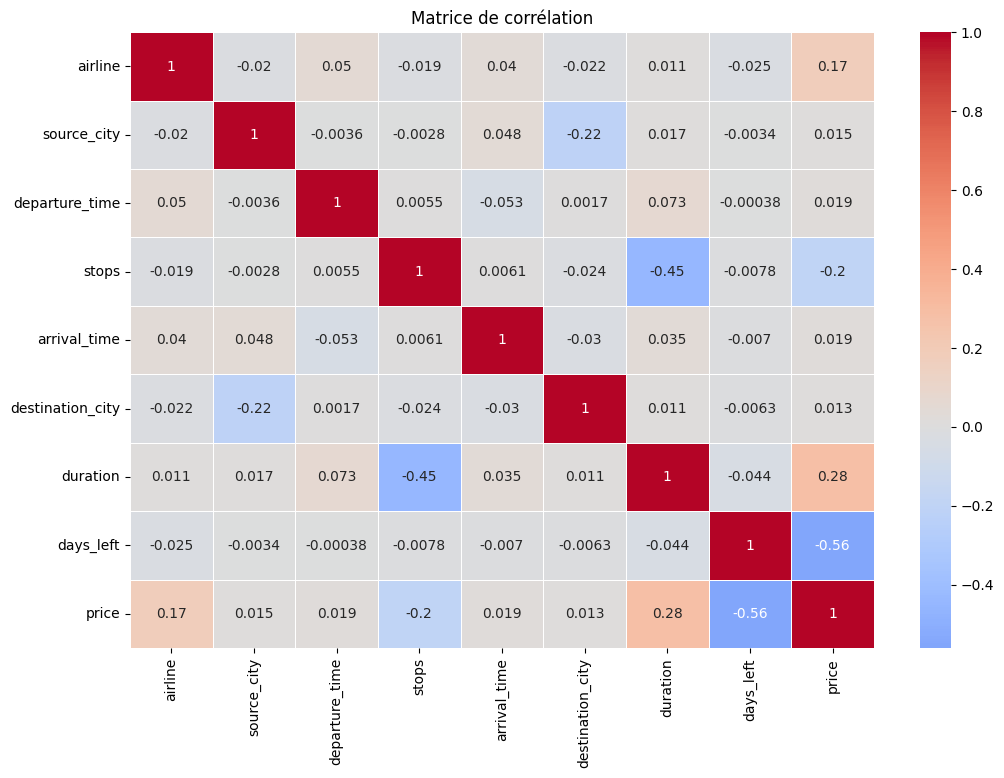

In [12]:
df2 = df.copy()
#encode les variables catégorielles using ordinal encoder
categorical_cols = df2.select_dtypes(include=['object','string']).columns
for col in categorical_cols:
    le = OrdinalEncoder()
    df2[col] = le.fit_transform(df2[[col]])

plt.figure(figsize=(12, 8))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

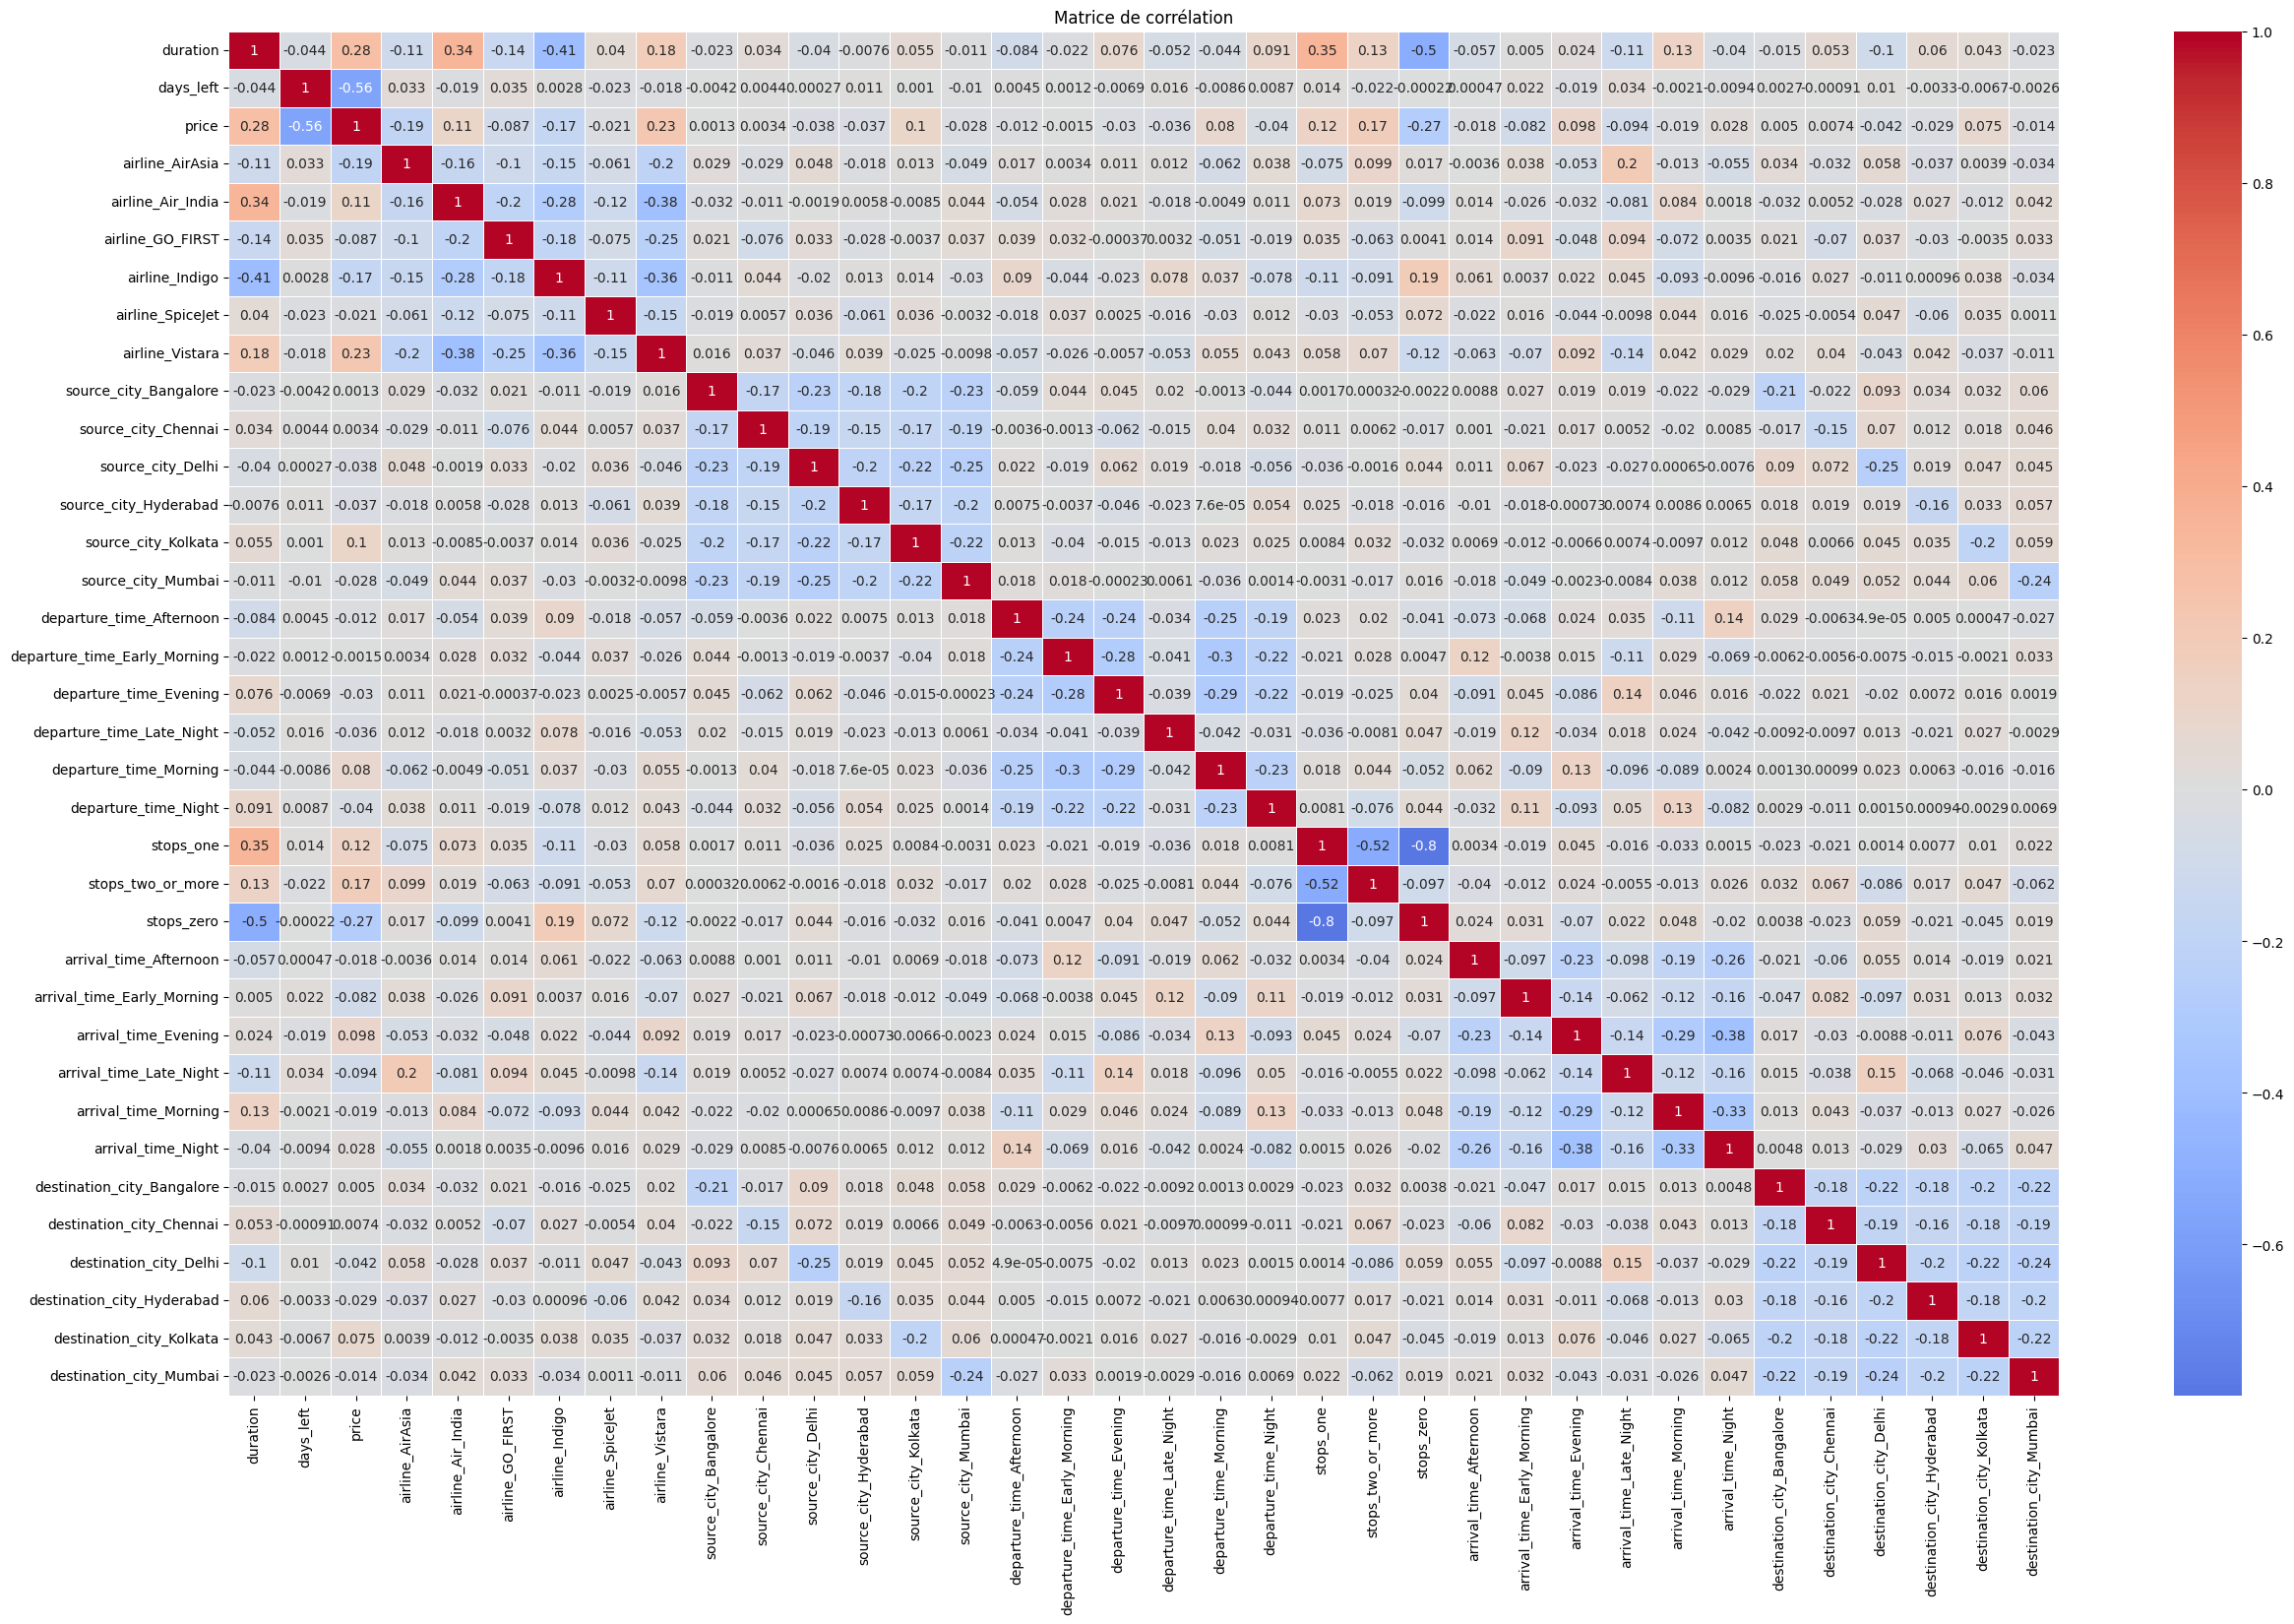

In [13]:
df3 = df.copy()
#encode les variables catégorielles using one hot encoder
categorical_cols = df3.select_dtypes(include=['object','string']).columns
df3 = pd.get_dummies(df3, columns=categorical_cols)

plt.figure(figsize=(30, 18))
sns.heatmap(df3.corr(), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

Avec le one-hot encoding, `stop` (~0.35) et la compagnie Air India (~0.34) commencent à montrer une corrélation avec `price`, ce qui n'était pas visible dans le modèle complet.

In [14]:
print(df.columns)

Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'duration', 'days_left', 'price'],
      dtype='object')


In [15]:
X = df.drop(columns=['price'])
y = df['price']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Préprocessing — Pipeline sklearn

Même pipeline que l'analyse principale, appliqué uniquement sur le sous-ensemble Economy :

- **Variables numériques** (`duration`, `days_left`) : imputation par médiane + `StandardScaler`.
- **Variables catégorielles** : imputation par valeur la plus fréquente + `OneHotEncoder`.

Le pipeline est entraîné sur `X_train` uniquement pour éviter toute fuite d'information.

In [17]:
num_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(include=['object','string']).columns

num_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
], verbose=True)

cat_process = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(handle_unknown='ignore'))
], verbose=True)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_preprocess, num_cols),
        ("cat", cat_process, categorical_cols)
    ], remainder='passthrough', 
    verbose_feature_names_out=False
)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
], verbose=True)

In [18]:
print(pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  Index(['duration', 'days_left'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
         

In [19]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing encoder, total=   0.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
[Pipeline] ............. (step 2 of 2) Processing model, total= 3.6min
RMSE: 1374.8570091386998
R²: 0.8657564133180247


Résultat très similaire au modèle de base. Le RMSE est légèrement réduit, ce qui était attendu en se concentrant uniquement sur Economy, où la variation de prix est plus homogène.

In [20]:
imputer = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['imputer']
imputer_categories = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['imputer']
print(dict(zip(num_cols, imputer.statistics_)))
print(dict(zip(categorical_cols, imputer_categories.statistics_)))

{'duration': np.float64(10.25), 'days_left': np.float64(26.0)}
{'airline': 'Vistara', 'source_city': 'Delhi', 'departure_time': 'Morning', 'stops': 'one', 'arrival_time': 'Night', 'destination_city': 'Delhi'}


In [21]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
rf_model = pipeline.named_steps['model']
importances = rf_model.feature_importances_

importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print(importances_df.head(10))

                     feature  importance
1                  days_left    0.508386
0                   duration    0.191566
3          airline_Air_India    0.031514
2            airline_AirAsia    0.025246
7            airline_Vistara    0.023491
5             airline_Indigo    0.017940
12       source_city_Kolkata    0.013031
20                 stops_one    0.012433
21         stops_two_or_more    0.011814
33  destination_city_Kolkata    0.011150


Sur le sous-dataset Economy, `days_left` devient la variable la plus importante (~50%), suivi de `duration` (~19%). C'est cohérent : plus on est proche du départ, plus le prix augmente, et la durée du vol influence aussi le tarif.

In [22]:
joblib.dump(pipeline, 'random_forest_flight_price_economy.pkl')

['random_forest_flight_price_economy.pkl']

In [23]:
loaded_model = joblib.load('random_forest_flight_price_economy.pkl')
y_pred_loaded = loaded_model.predict(X_test)

print(f"R² Score (loaded model): {r2_score(y_test, y_pred_loaded)}")

R² Score (loaded model): 0.8657564133180247


In [24]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
tree = pipeline.named_steps['model'].estimators_[0]

print(export_text(tree, feature_names=list(feature_names), max_depth=4))

|--- days_left <= -0.79
|   |--- duration <= -0.99
|   |   |--- duration <= -1.28
|   |   |   |--- days_left <= -1.67
|   |   |   |   |--- days_left <= -1.82
|   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |--- days_left >  -1.82
|   |   |   |   |   |--- truncated branch of depth 15
|   |   |   |--- days_left >  -1.67
|   |   |   |   |--- duration <= -1.38
|   |   |   |   |   |--- truncated branch of depth 18
|   |   |   |   |--- duration >  -1.38
|   |   |   |   |   |--- truncated branch of depth 24
|   |   |--- duration >  -1.28
|   |   |   |--- days_left <= -1.67
|   |   |   |   |--- duration <= -1.06
|   |   |   |   |   |--- truncated branch of depth 20
|   |   |   |   |--- duration >  -1.06
|   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |--- days_left >  -1.67
|   |   |   |   |--- duration <= -1.23
|   |   |   |   |   |--- truncated branch of depth 20
|   |   |   |   |--- duration >  -1.23
|   |   |   |   |   |--- truncated branch of depth 

## Conclusion

Sur le dataset Economy uniquement, le modèle prend davantage en compte `days_left` et `duration`, des variables qui étaient masquées par `class_ticket` dans le modèle complet.

Les scores restent proches du modèle de base. Pour aller plus loin, un feature engineering plus poussé ou d'autres algorithmes pourraient améliorer la précision sur les détails fins des prix.

## Analyse business et impact

**Impact métier :** sur le segment Economy, `days_left` est la variable la plus influente. Cela signifie que le prix d'un billet Economy dépend fortement de l'anticipation de l'achat — plus on réserve tôt, moins c'est cher. Cette information est directement exploitable pour conseiller les voyageurs sur le meilleur moment pour réserver.

**Limites :**
- Le modèle est entraîné sur environ 2/3 du dataset original (vols Economy uniquement).
- Les données couvrent un seul marché (Inde), ce qui limite la généralisation.

**Perspectives :** un feature engineering plus poussé (ex. : combinaison route + créneau horaire) pourrait améliorer la précision sur les détails fins des prix.